In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [380]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [381]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [382]:
key_path = './service_account/gentle-keyword-423715-j0-03be08ad6412.json'

credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/bigquery"]
)

In [383]:
from google.cloud import bigquery

client = bigquery.Client(
    credentials = credentials,
    project=credentials.project_id
)

In [384]:
query = """
SELECT
  u.id user_id,
  u.age,
  u.country,
  DATE(EXTRACT(YEAR FROM u.created_at), EXTRACT(MONTH FROM u.created_at), 1) created_account_date,
  o.order_id,
  DATE(EXTRACT(YEAR FROM o.delivered_at), EXTRACT(MONTH FROM o.delivered_at), 1) delivered_date,
  DATE(EXTRACT(YEAR FROM o.created_at), EXTRACT(MONTH FROM o.created_at), 1) order_date,
  o.num_of_item,
  oi.sale_price * o.num_of_item revenue,
  p.category,
  p.department,
  p.cost,
  e.id event_id,
  e.session_id,
  e.traffic_source traffic_session,
  e.event_type,
FROM `bigquery-public-data.thelook_ecommerce.users` u
LEFT JOIN `bigquery-public-data.thelook_ecommerce.order_items` oi
  ON oi.user_id = u.id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.orders` o
  ON u.id = o.user_id AND oi.order_id = o.order_id
INNER JOIN `bigquery-public-data.thelook_ecommerce.products` p
  ON oi.product_id = p.id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.events` e
  ON u.id = e.id
WHERE 
  o.status ='Complete'
"""

df = client.query(query).to_dataframe()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45632 entries, 0 to 45631
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               45632 non-null  Int64  
 1   age                   45632 non-null  Int64  
 2   country               45632 non-null  object 
 3   created_account_date  45632 non-null  dbdate 
 4   order_id              45632 non-null  Int64  
 5   delivered_date        45632 non-null  dbdate 
 6   order_date            45632 non-null  dbdate 
 7   num_of_item           45632 non-null  Int64  
 8   revenue               45632 non-null  float64
 9   category              45632 non-null  object 
 10  department            45632 non-null  object 
 11  cost                  45632 non-null  float64
 12  event_id              45632 non-null  Int64  
 13  session_id            45632 non-null  object 
 14  traffic_session       45632 non-null  object 
 15  event_type         

,user_id,age,country,created_account_date,order_id,delivered_date,order_date,num_of_item,revenue,category,department,cost,event_id,session_id,traffic_session,event_type
0,26965,29,Brasil,2020-04-01,33612,2020-04-01,2020-04-01,4,46.160000,Accessories,Women,5.19300,26965,56007e8b-d7ac-45e8-922b-7a9dc0d898bc,Email,department
1,26965,29,Brasil,2020-04-01,33612,2020-04-01,2020-04-01,4,47.599998,Active,Women,5.33120,26965,56007e8b-d7ac-45e8-922b-7a9dc0d898bc,Email,department
2,6448,33,Germany,2019-01-01,7949,2019-12-01,2019-12-01,1,13.110000,Fashion Hoodies & Sweatshirts,Women,6.37146,6448,82b247f2-426e-4d0a-90d1-3d1a422935de,Facebook,product
3,6448,33,Germany,2019-01-01,7948,2020-05-01,2020-05-01,1,13.990000,Leggings,Women,8.51991,6448,82b247f2-426e-4d0a-90d1-3d1a422935de,Facebook,product
4,40387,12,United States,2019-07-01,50206,2019-11-01,2019-11-01,2,29.000000,Active,Men,6.35100,40387,733ac4a1-8084-485b-90e5-b803774add42,Email,department


In [385]:
df['order_id'] = df['order_id'].astype(str)
df['user_id'] = df['user_id'].astype(str)
df['order_date'] = pd.to_datetime(df['order_date'])
df['created_account_date'] = pd.to_datetime(df['created_account_date'])
df['delivered_date'] = pd.to_datetime(df['delivered_date'])

print("Number of unique user_id: ", df['user_id'].nunique())

print(df.info())

Number of unique user_id:  27597
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45632 entries, 0 to 45631
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               45632 non-null  object        
 1   age                   45632 non-null  Int64         
 2   country               45632 non-null  object        
 3   created_account_date  45632 non-null  datetime64[ns]
 4   order_id              45632 non-null  object        
 5   delivered_date        45632 non-null  datetime64[ns]
 6   order_date            45632 non-null  datetime64[ns]
 7   num_of_item           45632 non-null  Int64         
 8   revenue               45632 non-null  float64       
 9   category              45632 non-null  object        
 10  department            45632 non-null  object        
 11  cost                  45632 non-null  float64       
 12  event_id              45632 non-null  Int

In [386]:
# Labeling data

df_sg = pd.read_csv('./result/segmentation-result.csv')
df_sg['user_id'] = df_sg['user_id'].astype(str)
print(df_sg.info())
df_sg.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14265 entries, 0 to 14264
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          14265 non-null  object 
 1   traffic_session  14265 non-null  object 
 2   total_click      14265 non-null  int64  
 3   total_order      14265 non-null  int64  
 4   total_item       14265 non-null  int64  
 5   revenue          14265 non-null  float64
 6   total_session    14265 non-null  int64  
 7   recency          14265 non-null  float64
 8   cluster          14265 non-null  int64  
 9   PCA1             14265 non-null  float64
 10  PCA2             14265 non-null  float64
dtypes: float64(4), int64(5), object(2)
memory usage: 1.2+ MB
None


,user_id,traffic_session,total_click,total_order,total_item,revenue,total_session,recency,cluster,PCA1,PCA2
0,10012,Adwords,1,1,1,37.680000,1,274.0,1,-0.288666,0.099264
1,10018,Email,4,2,10,350.770000,4,121.0,1,-0.116294,0.014914
2,10026,Adwords,1,1,1,39.990002,1,31.0,1,-0.148905,-0.632788
3,10033,Email,2,1,4,89.959999,2,0.0,1,-0.158757,0.022413
4,10043,Email,2,1,4,266.000000,2,92.0,1,-0.179105,0.025993


In [387]:
df_sg_selected = df_sg.copy()
df_sg_selected = df_sg_selected[df_sg_selected['cluster'] != 2].loc[:, ['user_id', 'total_order']]
df_sg_selected['flag'] = df_sg_selected['total_order'].apply(lambda x: 1 if x > 1 else 0)
df_sg_selected.drop('total_order', axis=1, inplace=True)
print(df_sg_selected['flag'].value_counts(normalize=1))
print(df_sg_selected.info())
df_sg_selected.head()

0    0.819039
1    0.180961
Name: flag, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12196 entries, 0 to 14264
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  12196 non-null  object
 1   flag     12196 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 285.8+ KB
None


,user_id,flag
0,10012,0
1,10018,1
2,10026,0
3,10033,0
4,10043,0


In [388]:
# Select user_id
selected_user_id = list(df_sg_selected['user_id'].values)
print("Total unique selected user id: ", len(selected_user_id))
df_selected = df[df['user_id'].isin(selected_user_id)]
print("Result unique selected user id: ", df_selected['user_id'].nunique())

# Only less than 2024 year created account
df_selected = df_selected[df_selected['created_account_date'] < pd.to_datetime('2024-01-01')]

print(df_selected.info())
df_selected.head()

Total unique selected user id:  12196
Result unique selected user id:  12196
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18096 entries, 106 to 45613
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               18096 non-null  object        
 1   age                   18096 non-null  Int64         
 2   country               18096 non-null  object        
 3   created_account_date  18096 non-null  datetime64[ns]
 4   order_id              18096 non-null  object        
 5   delivered_date        18096 non-null  datetime64[ns]
 6   order_date            18096 non-null  datetime64[ns]
 7   num_of_item           18096 non-null  Int64         
 8   revenue               18096 non-null  float64       
 9   category              18096 non-null  object        
 10  department            18096 non-null  object        
 11  cost                  18096 non-null  float64       


,user_id,age,country,created_account_date,order_id,delivered_date,order_date,num_of_item,revenue,category,department,cost,event_id,session_id,traffic_session,event_type
106,6452,56,Brasil,2019-05-01,7957,2020-04-01,2020-04-01,1,25.000000,Accessories,Men,9.825000,6452,6b13a46a-2485-484d-b397-155cf492e08e,Email,department
125,82639,56,Germany,2019-04-01,103205,2020-05-01,2020-05-01,2,43.980000,Jeans,Women,12.688230,82639,376b733b-0e3a-42a3-91ec-00a6f86706a4,Email,purchase
126,65310,68,Germany,2019-12-01,81382,2020-03-01,2020-03-01,3,74.909998,Underwear,Men,11.935660,65310,f188b0a5-d1a7-4c9f-be01-2649a6174e46,Facebook,department
128,65310,68,Germany,2019-12-01,81382,2020-03-01,2020-03-01,3,75.000000,Swim,Men,14.875000,65310,f188b0a5-d1a7-4c9f-be01-2649a6174e46,Facebook,department
138,65310,68,Germany,2019-12-01,81382,2020-03-01,2020-03-01,3,217.620003,Outerwear & Coats,Men,32.933161,65310,f188b0a5-d1a7-4c9f-be01-2649a6174e46,Facebook,department


In [389]:
cutoff = pd.to_datetime('2024-01-01')
temp_in = df_selected[df_selected['order_date'] < cutoff]
temp_out = df_selected[df_selected['order_date'] >= cutoff]

In [390]:
# Generate target

target = temp_out\
            .groupby('user_id')\
            .agg({'revenue':'sum'})\
            .rename(columns={'revenue': 'CLV'})\
            .assign(is_spend = 1)\
            .reset_index()

target

,user_id,CLV,is_spend
0,10018,20.950001,1
1,10026,39.990002,1
2,10043,266.000000,1
3,1005,75.000000,1
4,10075,39.950001,1
...,...,...,...
4824,99911,88.959999,1
4825,9992,408.000000,1
4826,99934,24.000000,1
4827,99956,17.990000,1


In [391]:
# Features
features = temp_in.copy()

# Delay day
features['delay_day'] = (features['delivered_date'] - features['order_date']) / pd.to_timedelta(1, 'day')

# Aggregation
map_agg = {
  'age': 'first',
  'order_id': 'nunique',
  'session_id': 'count',
  'revenue': 'sum',
  'num_of_item': 'sum',
  'delay_day': ['mean', 'sum'],
  'order_date': 'max',
  'cost' : 'mean', 
  'created_account_date': 'min',
  'traffic_session': pd.Series.mode,
}

map_rename = {
  'age_first': 'age',
  'order_id_nunique': 'frequency',
  'session_id_count': 'total_session',
  'revenue_sum': 'monetary',
  'num_of_item_sum': 'num_of_item',
}

features = features\
            .groupby('user_id')\
            .agg(map_agg)\
            .reset_index()
features.columns = [c[0] if c[-1] == "" else "_".join(c) for c in features.columns]

# Traffic session handling
features = pd.concat([features, 
                        pd.get_dummies(features.rename(columns={'traffic_session_mode': 'traffic_session'})['traffic_session'],
                        prefix='traffic_session', dtype=int)], axis=1)

# Create recency field
features['recency'] = (cutoff - features['order_date_max']) / pd.to_timedelta(1, 'day')

# Create account age field
features['age_account'] = (cutoff - features['created_account_date_min']) / pd.to_timedelta(1, 'day')

features = features.drop(['order_date_max', 'created_account_date_min'], axis=1).rename(columns=map_rename)

print(features.info())
features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   6145 non-null   object 
 1   age                       6145 non-null   Int64  
 2   frequency                 6145 non-null   int64  
 3   total_session             6145 non-null   int64  
 4   monetary                  6145 non-null   float64
 5   num_of_item               6145 non-null   Int64  
 6   delay_day_mean            6145 non-null   float64
 7   delay_day_sum             6145 non-null   float64
 8   cost_mean                 6145 non-null   float64
 9   traffic_session_mode      6145 non-null   object 
 10  traffic_session_Adwords   6145 non-null   int32  
 11  traffic_session_Email     6145 non-null   int32  
 12  traffic_session_Facebook  6145 non-null   int32  
 13  traffic_session_Organic   6145 non-null   int32  
 14  traffic_

,user_id,age,frequency,total_session,monetary,num_of_item,delay_day_mean,delay_day_sum,cost_mean,traffic_session_mode,traffic_session_Adwords,traffic_session_Email,traffic_session_Facebook,traffic_session_Organic,traffic_session_YouTube,recency,age_account
0,10012,53,1,1,37.680000,1,0.0,0.0,19.66896,Adwords,1,0,0,0,0,122.0,334.0
1,10018,14,1,3,329.819999,9,0.0,0.0,21.84522,Email,0,1,0,0,0,549.0,822.0
2,10050,15,1,1,85.000000,1,0.0,0.0,42.84000,Adwords,1,0,0,0,0,153.0,1645.0
3,10075,27,1,1,45.000000,1,31.0,31.0,27.27000,Adwords,1,0,0,0,0,365.0,579.0
4,10078,67,1,1,94.000000,1,0.0,0.0,49.35000,Adwords,1,0,0,0,0,31.0,275.0


In [392]:
final = features.merge(target, on='user_id', how='left').fillna(0).drop('user_id', axis=1)
print(final.info())
final.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6145 entries, 0 to 6144
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       6145 non-null   Int64  
 1   frequency                 6145 non-null   int64  
 2   total_session             6145 non-null   int64  
 3   monetary                  6145 non-null   float64
 4   num_of_item               6145 non-null   Int64  
 5   delay_day_mean            6145 non-null   float64
 6   delay_day_sum             6145 non-null   float64
 7   cost_mean                 6145 non-null   float64
 8   traffic_session_mode      6145 non-null   object 
 9   traffic_session_Adwords   6145 non-null   int32  
 10  traffic_session_Email     6145 non-null   int32  
 11  traffic_session_Facebook  6145 non-null   int32  
 12  traffic_session_Organic   6145 non-null   int32  
 13  traffic_session_YouTube   6145 non-null   int32  
 14  recency 

,age,frequency,total_session,monetary,num_of_item,delay_day_mean,delay_day_sum,cost_mean,traffic_session_mode,traffic_session_Adwords,traffic_session_Email,traffic_session_Facebook,traffic_session_Organic,traffic_session_YouTube,recency,age_account,CLV,is_spend
0,53,1,1,37.680000,1,0.0,0.0,19.66896,Adwords,1,0,0,0,0,122.0,334.0,0.000000,0.0
1,14,1,3,329.819999,9,0.0,0.0,21.84522,Email,0,1,0,0,0,549.0,822.0,20.950001,1.0
2,15,1,1,85.000000,1,0.0,0.0,42.84000,Adwords,1,0,0,0,0,153.0,1645.0,0.000000,0.0
3,27,1,1,45.000000,1,31.0,31.0,27.27000,Adwords,1,0,0,0,0,365.0,579.0,39.950001,1.0
4,67,1,1,94.000000,1,0.0,0.0,49.35000,Adwords,1,0,0,0,0,31.0,275.0,0.000000,0.0


In [393]:
final.describe()

,age,frequency,total_session,monetary,num_of_item,delay_day_mean,delay_day_sum,cost_mean,traffic_session_Adwords,traffic_session_Email,traffic_session_Facebook,traffic_session_Organic,traffic_session_YouTube,recency,age_account,CLV,is_spend
count,6145.0,6145.000000,6145.000000,6145.000000,6145.0,6145.000000,6145.000000,6145.000000,6145.000000,6145.000000,6145.000000,6145.000000,6145.000000,6145.000000,6145.000000,6145.000000,6145.000000
mean,40.723678,1.137998,1.656957,187.129340,3.150529,3.952418,6.646379,27.940628,0.305777,0.450285,0.099430,0.048007,0.096501,142.694711,719.471277,23.657299,0.147925
std,17.056531,0.379954,1.015574,299.421775,4.008815,9.934628,18.899054,24.522596,0.460773,0.497563,0.299263,0.213797,0.295301,173.565026,492.329643,122.371387,0.355055
min,12.0,1.000000,1.000000,2.780000,1.0,0.000000,0.000000,0.992460,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,31.000000,0.000000,0.000000
25%,26.0,1.000000,1.000000,32.450001,1.0,0.000000,0.000000,13.255580,0.000000,0.000000,0.000000,0.000000,0.000000,61.000000,306.000000,0.000000,0.000000
50%,41.0,1.000000,1.000000,74.500000,1.0,0.000000,0.000000,21.469845,0.000000,0.000000,0.000000,0.000000,0.000000,92.000000,610.000000,0.000000,0.000000
75%,56.0,1.000000,2.000000,198.000000,4.0,0.000000,0.000000,34.009900,1.000000,1.000000,0.000000,0.000000,0.000000,153.000000,1064.000000,0.000000,0.000000
max,70.0,4.000000,10.000000,4298.560001,36.0,31.000000,152.000000,409.059001,1.000000,1.000000,1.000000,1.000000,1.000000,1736.000000,1826.000000,3363.680004,1.000000


C:\Users\Baha Tegar\AppData\Local\Temp\ipykernel_10660\2069806701.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = final.corr()


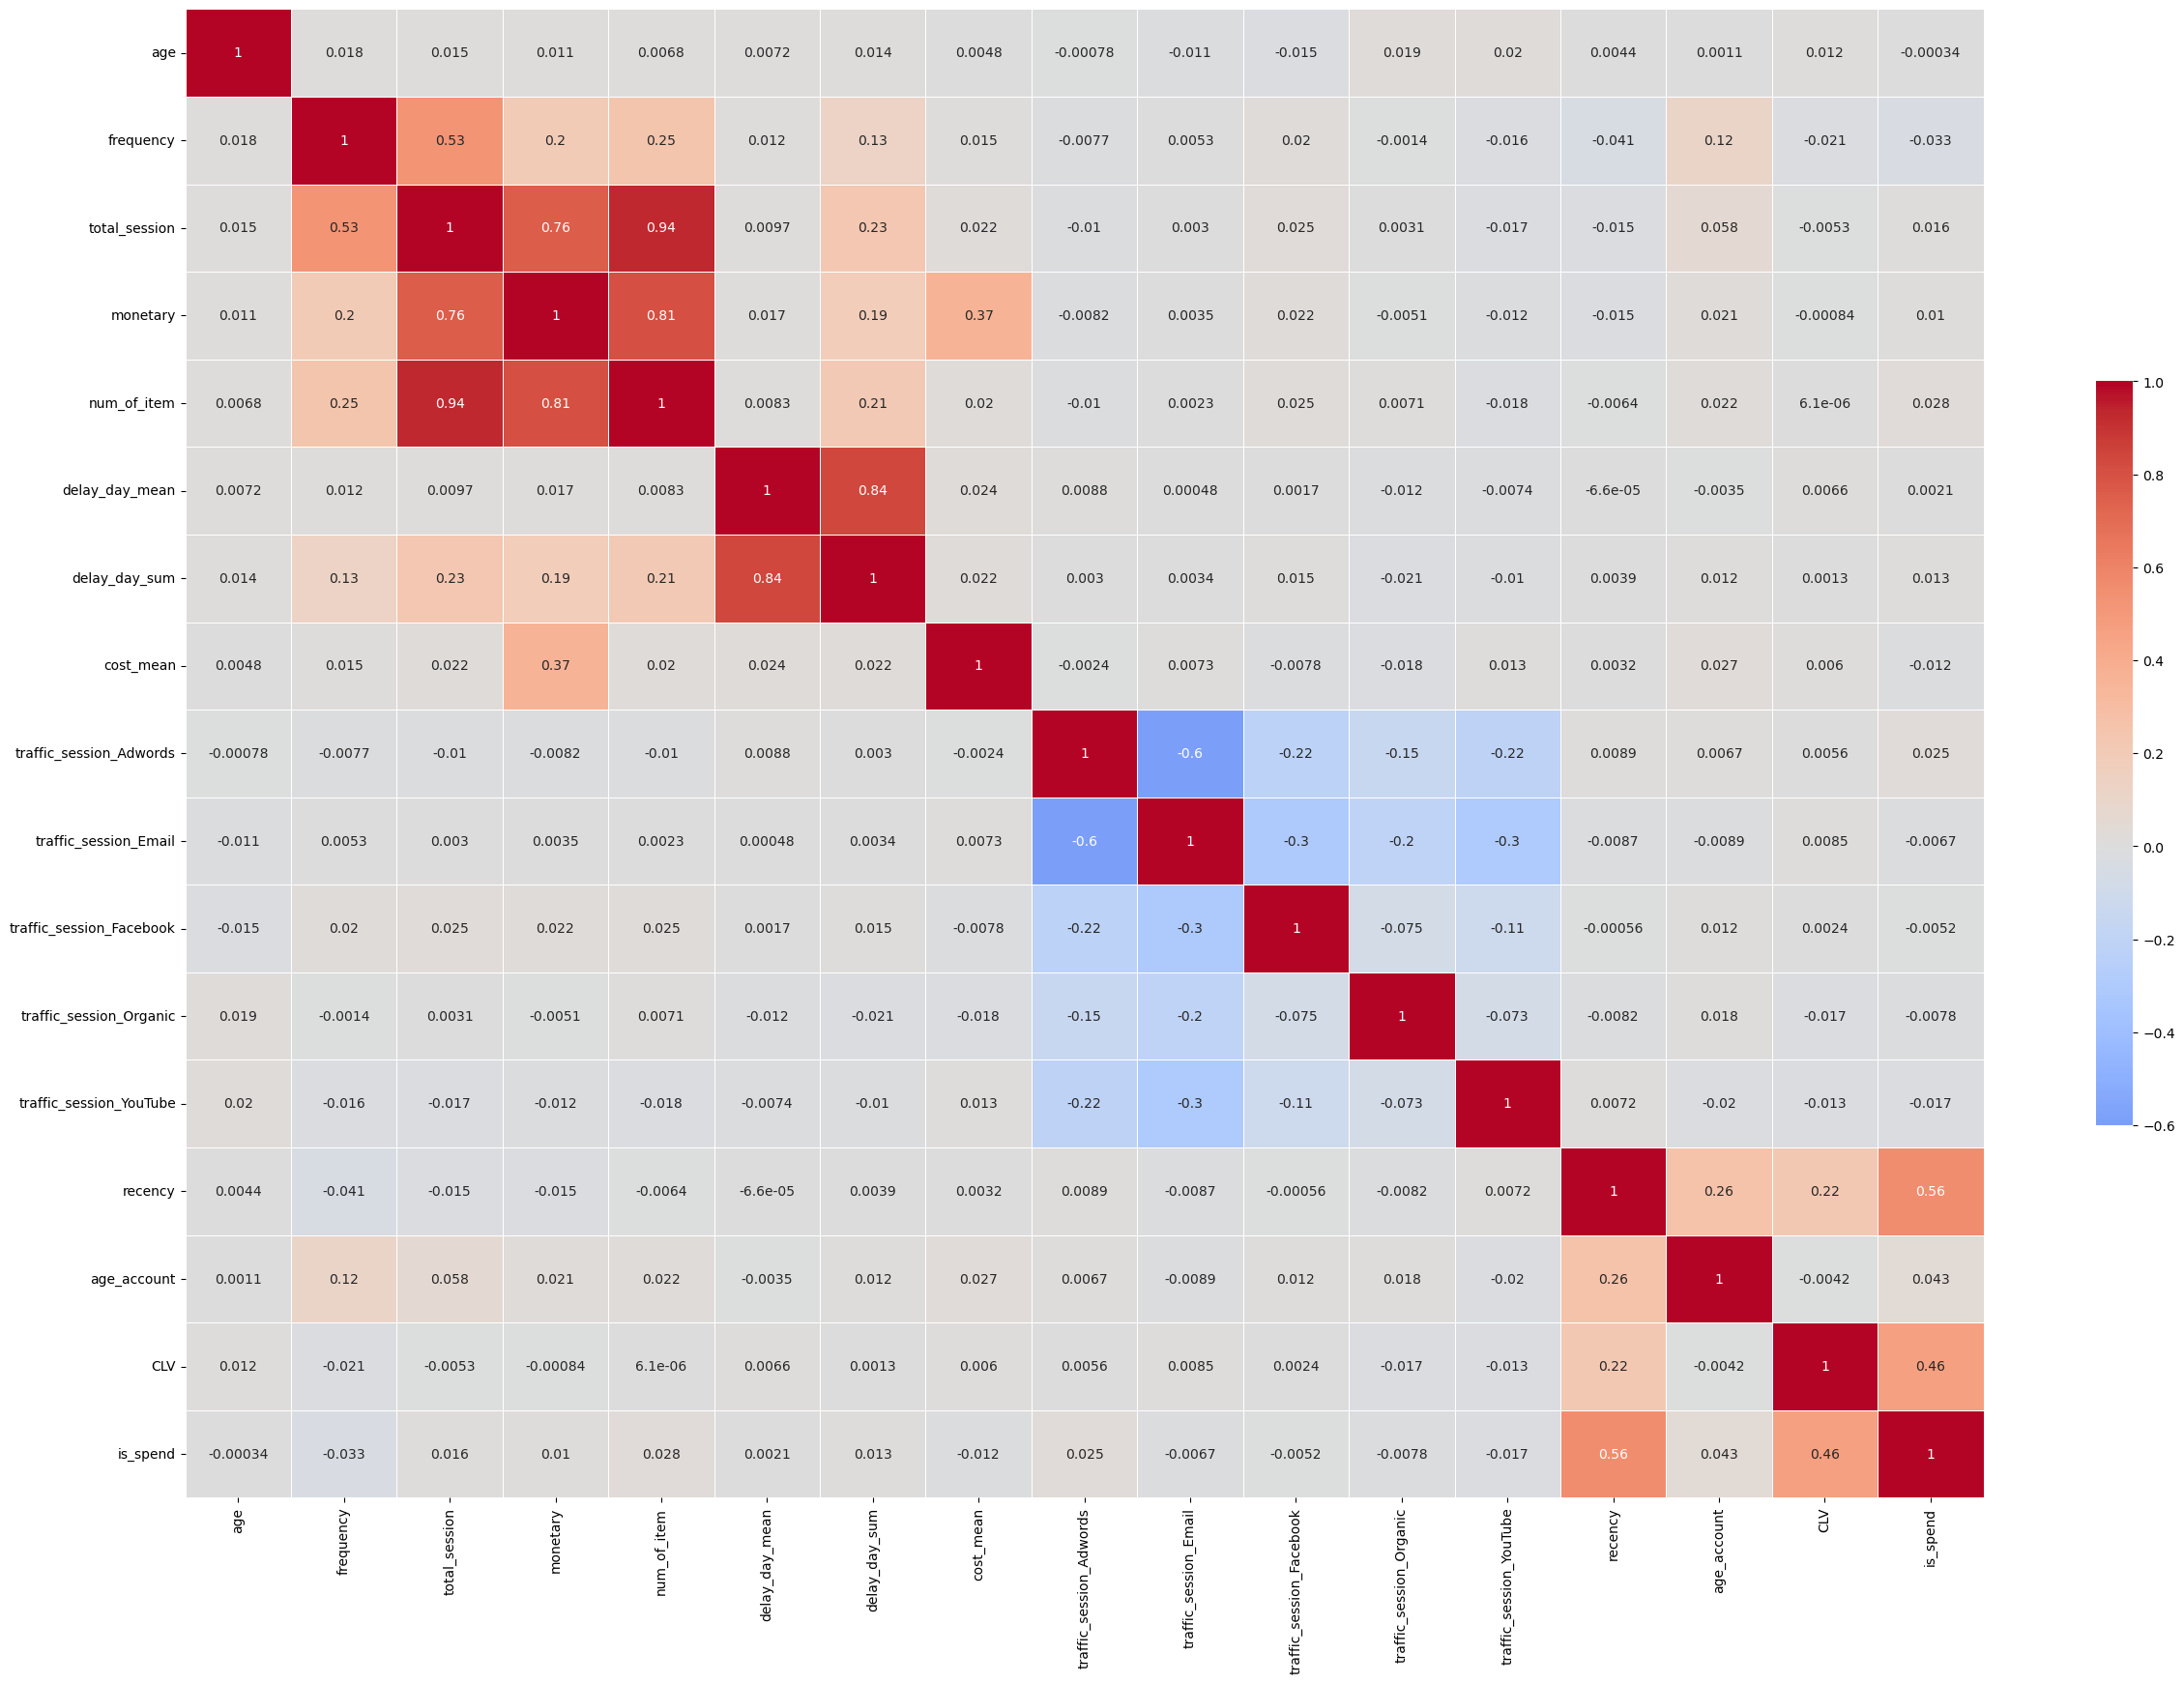

In [394]:
corr = final.corr()

plt.figure(figsize=(30, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [395]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target_clf = 'is_spend'
target_reg = 'CLV'
targets = ['CLV', 'is_spend']

X = final[['frequency', 'monetary', 'total_session', 
         'num_of_item', 'delay_day_sum', 'traffic_session_Adwords', 
         'traffic_session_Email', 'traffic_session_Facebook',
         'traffic_session_Organic', 'traffic_session_YouTube',
         'recency', 'age_account']]

sc_columns = ['monetary', 'delay_day_sum', 'age_account']
sc = StandardScaler()
X[sc_columns] = sc.fit_transform(X[sc_columns])


y = final[target_clf]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}\n Test shape: {X_test.shape}")
print("Target label distribution: \n", y_train.value_counts(normalize=True))
print("Test label distribution: \n", y_test.value_counts(normalize=True))

Train shape: (4916, 12)
 Test shape: (1229, 12)
Target label distribution: 
 0.0    0.852116
1.0    0.147884
Name: is_spend, dtype: float64
Test label distribution: 
 0.0    0.851912
1.0    0.148088
Name: is_spend, dtype: float64


C:\Users\Baha Tegar\AppData\Local\Temp\ipykernel_10660\1515461740.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[sc_columns] = sc.fit_transform(X[sc_columns])


In [396]:
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
undersample = RandomUnderSampler()
X_train, y_train = undersample.fit_resample(X_train, y_train)
print("Train label distribution: \n", y_train.value_counts(normalize=True))

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

Train label distribution: 
 0.0    0.5
1.0    0.5
Name: is_spend, dtype: float64


LogisticRegression(max_iter=1000)

In [397]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

# undersample = RandomUnderSampler()
# X_test, y_test = undersample.fit_resample(X_test, y_test)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 0]
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("ROC AUC Score : ", roc_auc_score(y_test, y_proba))


Recall:  0.6153846153846154
Precision:  0.36129032258064514
ROC AUC Score :  0.21697261668608375


In [398]:
columns = X_train.columns
coef_lr = lr.coef_

pd.DataFrame(np.exp(coef_lr), columns=columns).T

,0
frequency,1.168169
monetary,1.038517
total_session,1.027500
num_of_item,1.016076
delay_day_sum,1.016967
traffic_session_Adwords,1.252542
traffic_session_Email,1.114227
traffic_session_Facebook,0.930816
traffic_session_Organic,1.127403
traffic_session_YouTube,0.673618


In [399]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=3, random_state=42)

In [400]:
clf.predict_proba(X_test)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [401]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 0]
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("ROC AUC Score : ", roc_auc_score(y_test, y_proba))

Recall:  0.7362637362637363
Precision:  0.31678486997635935
ROC AUC Score :  0.21913998131763174


In [402]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [403]:
y_pred = forest.predict(X_test)
y_proba = forest.predict_proba(X_test)[:, 0]
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("ROC AUC Score : ", roc_auc_score(y_test, y_proba))

Recall:  0.6483516483516484
Precision:  0.44696969696969696
ROC AUC Score :  0.17687374707432013


In [404]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic', random_state=123)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [405]:
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 0]
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("ROC AUC Score : ", roc_auc_score(y_test, y_proba))

Recall:  0.6813186813186813
Precision:  0.3862928348909657
ROC AUC Score :  0.19076482256998017


In [406]:
from sklearn.ensemble import IsolationForest

isoForest = IsolationForest(random_state=42)
isoForest.fit(X)

IsolationForest(random_state=42)

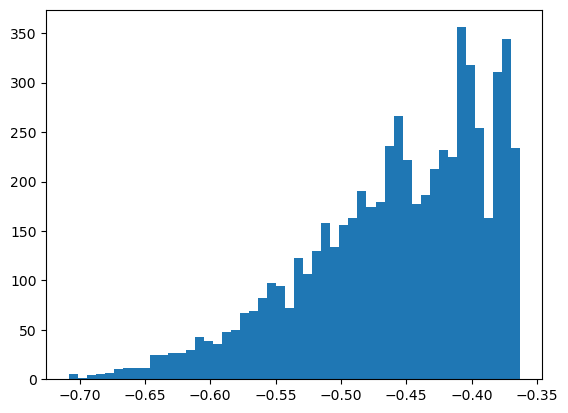

In [407]:
scores = isoForest.score_samples(X)
plt.hist(scores, bins=50)
plt.show()

ROC AUC Score: 0.64


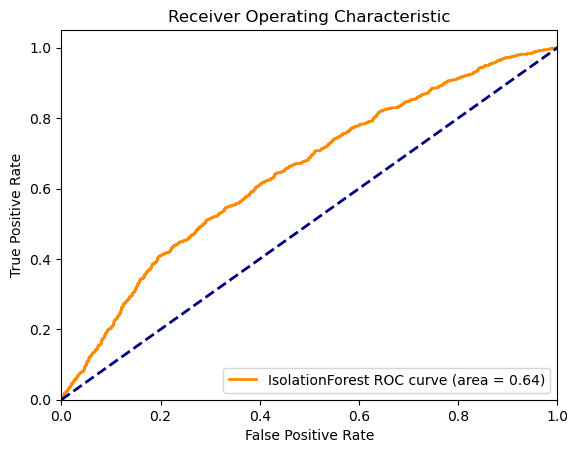

In [408]:
from sklearn.metrics import roc_auc_score, roc_curve

iso_roc_auc = roc_auc_score(final['is_spend'].values, -1 * scores)
print(f'ROC AUC Score: {iso_roc_auc:.2f}')
iso_fpr, iso_tpr, iso_thresholds = roc_curve(final['is_spend'].values, -1 * scores)

# Plot both ROC curves
plt.figure()
plt.plot(iso_fpr, iso_tpr, color='darkorange', lw=2, label=f'IsolationForest ROC curve (area = {iso_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

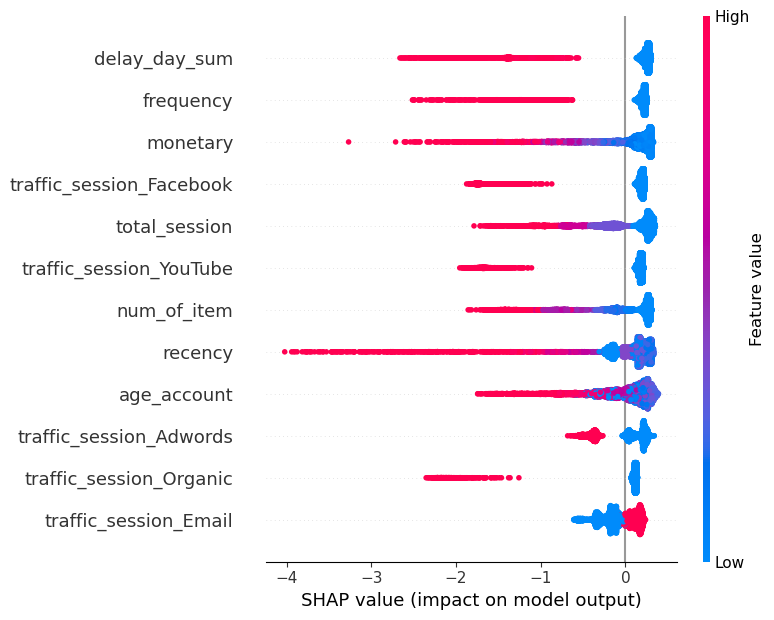

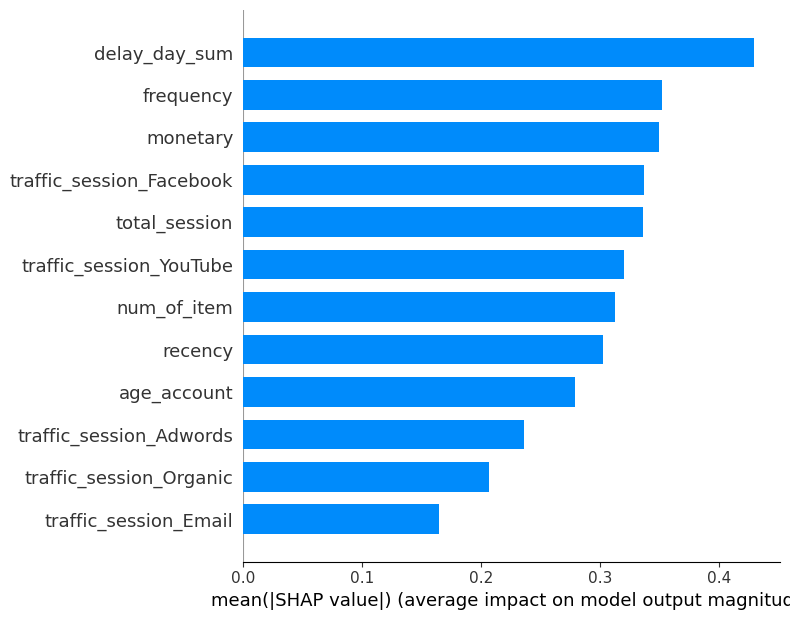

In [409]:
import shap

# Create a SHAP explainer object for the model
explainer = shap.Explainer(isoForest)

# Calculate SHAP values for the dataset
shap_values = explainer(X)

# Summary plot of SHAP values
feature_names = X.columns
shap.summary_plot(shap_values, X, feature_names=feature_names)

# Bar plot of feature importance based on SHAP values
shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="bar")


In [410]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Absolute SHAP Value': mean_abs_shap_values
}).sort_values(by='Mean Absolute SHAP Value', ascending=False)

feature_importance_df

,Feature,Mean Absolute SHAP Value
4,delay_day_sum,0.429581
0,frequency,0.351825
1,monetary,0.349579
7,traffic_session_Facebook,0.336858
2,total_session,0.335631
9,traffic_session_YouTube,0.319711
3,num_of_item,0.312276
10,recency,0.302366
11,age_account,0.278419
5,traffic_session_Adwords,0.235655


In [411]:
result = final.copy()
result['probability'] = -1 * scores
result.head()

,age,frequency,total_session,monetary,num_of_item,delay_day_mean,delay_day_sum,cost_mean,traffic_session_mode,traffic_session_Adwords,traffic_session_Email,traffic_session_Facebook,traffic_session_Organic,traffic_session_YouTube,recency,age_account,CLV,is_spend,probability
0,53,1,1,37.680000,1,0.0,0.0,19.66896,Adwords,1,0,0,0,0,122.0,334.0,0.000000,0.0,0.392917
1,14,1,3,329.819999,9,0.0,0.0,21.84522,Email,0,1,0,0,0,549.0,822.0,20.950001,1.0,0.531492
2,15,1,1,85.000000,1,0.0,0.0,42.84000,Adwords,1,0,0,0,0,153.0,1645.0,0.000000,0.0,0.433745
3,27,1,1,45.000000,1,31.0,31.0,27.27000,Adwords,1,0,0,0,0,365.0,579.0,39.950001,1.0,0.498428
4,67,1,1,94.000000,1,0.0,0.0,49.35000,Adwords,1,0,0,0,0,31.0,275.0,0.000000,0.0,0.411577


In [415]:
df.head()

,user_id,age,country,created_account_date,order_id,delivered_date,order_date,num_of_item,revenue,category,department,cost,event_id,session_id,traffic_session,event_type
0,26965,29,Brasil,2020-04-01,33612,2020-04-01,2020-04-01,4,46.160000,Accessories,Women,5.19300,26965,56007e8b-d7ac-45e8-922b-7a9dc0d898bc,Email,department
1,26965,29,Brasil,2020-04-01,33612,2020-04-01,2020-04-01,4,47.599998,Active,Women,5.33120,26965,56007e8b-d7ac-45e8-922b-7a9dc0d898bc,Email,department
2,6448,33,Germany,2019-01-01,7949,2019-12-01,2019-12-01,1,13.110000,Fashion Hoodies & Sweatshirts,Women,6.37146,6448,82b247f2-426e-4d0a-90d1-3d1a422935de,Facebook,product
3,6448,33,Germany,2019-01-01,7948,2020-05-01,2020-05-01,1,13.990000,Leggings,Women,8.51991,6448,82b247f2-426e-4d0a-90d1-3d1a422935de,Facebook,product
4,40387,12,United States,2019-07-01,50206,2019-11-01,2019-11-01,2,29.000000,Active,Men,6.35100,40387,733ac4a1-8084-485b-90e5-b803774add42,Email,department


In [412]:
# Final result
selected_user_all = list(df_sg['user_id'].values)

df_finalize = df[df['user_id'].isin(selected_user_all)]

# Delay day
df_finalize['delay_day'] = (df_finalize['delivered_date'] - df_finalize['order_date']) / pd.to_timedelta(1, 'day')

# Aggregation
map_agg = {
  'age': 'first',
  'order_id': 'nunique',
  'session_id': 'count',
  'revenue': 'sum',
  'num_of_item': 'sum',
  'delay_day': ['mean', 'sum'],
  'order_date': 'max',
  'cost' : 'mean', 
  'created_account_date': 'min',
  'traffic_session': pd.Series.mode
}

map_rename = {
  'age_first': 'age',
  'order_id_nunique': 'frequency',
  'session_id_count': 'total_session',
  'revenue_sum': 'monetary',
  'num_of_item_sum': 'num_of_item',
}

df_finalize = df_finalize\
            .groupby('user_id')\
            .agg(map_agg)\
            .reset_index()
df_finalize.columns = [c[0] if c[-1] == "" else "_".join(c) for c in df_finalize.columns]

# Traffic session handling
df_finalize = pd.concat([df_finalize, 
                        pd.get_dummies(df_finalize.rename(columns={'traffic_session_mode': 'traffic_session'})['traffic_session'],
                        prefix='traffic_session', dtype=int)], axis=1)

# Create recency field
cutoff = pd.to_datetime('2024-06-01')
df_finalize['recency'] = (cutoff - df_finalize['order_date_max']) / pd.to_timedelta(1, 'day')

# Create account age field
df_finalize['age_account'] = (cutoff - df_finalize['created_account_date_min']) / pd.to_timedelta(1, 'day')

df_finalize = df_finalize.drop(['order_date_max', 'created_account_date_min', 'traffic_session_mode'], axis=1).rename(columns=map_rename)

print(df_finalize.info())
df_finalize.head()

C:\Users\Baha Tegar\AppData\Local\Temp\ipykernel_10660\3237193230.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finalize['delay_day'] = (df_finalize['delivered_date'] - df_finalize['order_date']) / pd.to_timedelta(1, 'day')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14265 entries, 0 to 14264
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   14265 non-null  object 
 1   age                       14265 non-null  Int64  
 2   frequency                 14265 non-null  int64  
 3   total_session             14265 non-null  int64  
 4   monetary                  14265 non-null  float64
 5   num_of_item               14265 non-null  Int64  
 6   delay_day_mean            14265 non-null  float64
 7   delay_day_sum             14265 non-null  float64
 8   cost_mean                 14265 non-null  float64
 9   traffic_session_Adwords   14265 non-null  int32  
 10  traffic_session_Email     14265 non-null  int32  
 11  traffic_session_Facebook  14265 non-null  int32  
 12  traffic_session_Organic   14265 non-null  int32  
 13  traffic_session_YouTube   14265 non-null  int32  
 14  recenc

,user_id,age,frequency,total_session,monetary,num_of_item,delay_day_mean,delay_day_sum,cost_mean,traffic_session_Adwords,traffic_session_Email,traffic_session_Facebook,traffic_session_Organic,traffic_session_YouTube,recency,age_account
0,10012,53,1,1,37.680000,1,0.0,0.0,19.668960,1,0,0,0,0,274.0,486.0
1,10018,14,2,4,350.770000,10,0.0,0.0,18.237990,0,1,0,0,0,121.0,974.0
2,10026,46,1,1,39.990002,1,0.0,0.0,20.634841,1,0,0,0,0,31.0,366.0
3,10033,22,1,2,89.959999,4,0.0,0.0,11.085010,0,1,0,0,0,0.0,61.0
4,10043,45,1,2,266.000000,4,0.0,0.0,28.426500,0,1,0,0,0,92.0,213.0


C:\Users\Baha Tegar\AppData\Local\Temp\ipykernel_10660\322232490.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[sc_columns] = sc.fit_transform(X[sc_columns])


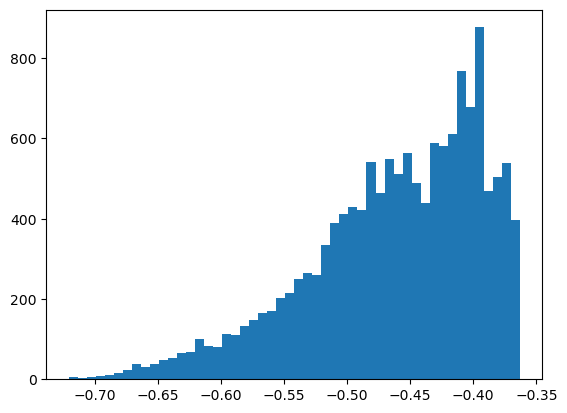

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14265 entries, 0 to 14264
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      14265 non-null  object 
 1   frequency    14265 non-null  int64  
 2   monetary     14265 non-null  float64
 3   recency      14265 non-null  float64
 4   probability  14265 non-null  float64
 5   category-1   14265 non-null  object 
 6   category-2   14265 non-null  object 
 7   category-3   14265 non-null  object 
 8   cluster      14265 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 1.1+ MB
None


,user_id,frequency,monetary,recency,probability,category-1,category-2,category-3,cluster
0,10012,1,37.680000,274.0,0.425849,Shorts,,,1
1,10018,2,350.770000,121.0,0.532256,Blazers & Jackets,Intimates,Sleep & Lounge,1
2,10026,1,39.990002,31.0,0.403185,Fashion Hoodies & Sweatshirts,,,1
3,10033,1,89.959999,0.0,0.426454,Accessories,Intimates,,1
4,10043,1,266.000000,92.0,0.410743,Pants,,,1


In [442]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target_clf = 'is_spend'
target_reg = 'CLV'
targets = ['CLV', 'is_spend']

X = df_finalize[['frequency', 'monetary', 'total_session', 
                 'num_of_item', 'delay_day_sum', 'traffic_session_Adwords', 
                 'traffic_session_Email', 'traffic_session_Facebook',
                 'traffic_session_Organic', 'traffic_session_YouTube',
                 'recency', 'age_account']]

sc_columns = ['monetary', 'delay_day_sum', 'age_account']
sc = StandardScaler()
X[sc_columns] = sc.fit_transform(X[sc_columns])


y = final[target_clf]

scores = isoForest.score_samples(X)
plt.hist(scores, bins=50)
plt.show()


product = df.groupby('user_id').agg({'category': pd.Series.mode}).reset_index()
product['category'] = product['category'].apply(lambda x: [x] if type(x) == str else x)
product['category-1'] = product['category'].apply(lambda x: x[0] if len(x) > 0 else "")
product['category-2'] = product['category'].apply(lambda x: x[1] if len(x) > 1 else "")
product['category-3'] = product['category'].apply(lambda x: x[2] if len(x) > 2 else "")
product = product.drop('category', axis=1)

result = df_finalize[['user_id', 'frequency', 'monetary', 'recency']].copy()
result['probability'] = -1 * scores
result = result.merge(product, on='user_id')
result = result.merge(df_sg[['user_id', 'cluster']], on='user_id')
print(result.info())
result.head()

In [443]:
result.to_csv('./result/potential-customers.csv', index=False)
feature_importance_df.to_csv('./result/feat_imp-pred-cust.csv', index=False)